<a href="https://colab.research.google.com/github/germansuarez017/Sentiment-Analysis-DeepLearningCourse/blob/main/Proyecto_Marvik_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyecto Marvik - Sentiment Analysis**
Para este proyecto utilizaremos tweets etiquetados provenientes de países hispanohablantes (Costa Rica, España, México, Perú, Puerto Rico y Uruguay) conseguidos de la página de TASS: Workshop on Semantic Analysis at SEPLN -http://tass.sepln.org/-.

En la primer parte intentaremos predecir el sentimiento (Positivo o Negativo) de los tweets utilizando una red neuronal LSTM y diversos modelos de machine learning.
Para la segunda parte del ejercicio nos concentraremos en predecir el país de origen de los tweets utilizando una red neuronal LSTM y aplicando SMOTE sampling

In [ ]:
# =======================================
# SENTIMENT ANALYSIS
# =======================================

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#upgrade library for plotting the confusion matrix
%pip install mlxtend --upgrade

     |████████████████████████████████| 1.3 MB 23.4 MB/s 
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [ ]:
#clone github repository
! git clone https://github.com/germansuarez017/Sentiment-Analysis-DeepLearningCourse.git

Cloning into 'Sentiment-Analysis-DeepLearningCourse'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 38 (delta 11), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (38/38), done.


# **Parte 1 - Armado de dataframe**

Primero pasaremos los diferentes archivos XML a un dataframe de pandas donde podremos ver la etiqueta del sentimiento asociado y de que país proviene. En una segunda instancia, eliminaremos los tweets que no tienen etiqueta o si la misma es neutral quedándonos solo con los sentimientos positivos y negativos.

In [ ]:
#unzip files
! unzip '/content/Sentiment-Analysis-DeepLearningCourse/XML_files.zip' > /dev/null

In [ ]:
#function to replace spanish punctuations in order not to loose the letters afterwards
def normalize(s):
    replacements = (
        ('á', 'a'),
        ('é', 'e'),
        ('í', 'i'),
        ('ó', 'o'),
        ('ú', 'u'),
        ('ñ', 'n')
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s

In [ ]:
import pandas as pd
import numpy as np
import re
import os
import glob
# this library is needed to read XML files for converting it into CSV
import xml.etree.ElementTree as ET
import shutil
import csv

# Convert xml files into one CSV
# Function that will extract column data for our CSV file
# ET = Element tree is used to parse, navigate, explore and populate xml files
def xml_to_csv(path):
    '''
    Creates a dataframe populated with the XML information
    :param path: path to the folder containing the XML files
    :return: a dataframe with the information from the XML files
    '''
    xml_list = []
    dataset_type = ''
    for xml_file in glob.glob(path + '/*.xml'):
        
        #checks what type of dataset is
        if 'train' in xml_file:
          dataset_type = 'train'
        if 'test' in xml_file:
          dataset_type = 'test'
        if 'dev' in xml_file:
          dataset_type = 'val'
        
        #checks country
        country = xml_file[36:38]
        
        tree = ET.parse(xml_file)                           # Reads the xml file and initialize the tree
        root = tree.getroot()
        
        for tweet in root.findall('tweet'):
          value = (normalize(tweet.find('content').text),
                   tweet.find('date').text,
                   tweet.find('sentiment')[0][0].text,
                   country,
                   dataset_type)
          xml_list.append(value)
    column_name = ['tweet_unclean', 'date', 'sentiment', 'country', 'dataset_type']
    xml_df = pd.DataFrame(xml_list, columns = column_name)
    return xml_df

In [ ]:
#converts xml files into csv
path_xml = '/content/XML_files'
df = xml_to_csv(path_xml)

In [ ]:
#discard test tweets, they are untagged
df = df[df.dataset_type != 'test']

#lets stay with the tweets, sentiment and country
df = df[['tweet_unclean', 'sentiment', 'country']]

#discard NEU or NONE tags
df = df[df.sentiment != 'NEU']
df = df[df.sentiment != 'NONE']

In [ ]:
#converts dataframe to csv
# path = '/content/Sentiment-Analysis-DeepLearningCourse'
# df.to_csv(path + '/' + 'tweetslatinamerica.csv')

Viendo el gráfico debajo podemos concluir que el dataset está relativamente balanceado.

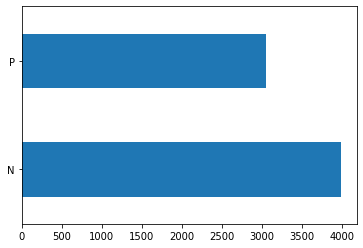

In [ ]:
#check how many positive and negative tags are in the dataset
ax = df['sentiment'].value_counts(sort=False).plot(kind='barh')

# **Parte 2 - Limpieza de tweets**
En esta parte limpiaremos los tweets de la siguiente manera:
- Pasaremos todo a minúscula
- Quitaremos puntuaciones y símbolos
- Quitaremos las referencias a los retweets (rt)
- Quitaremos las stopwords
-	Haremos stemmering a las palabras, intentando reducir el vocabulario total
- Quitaremos todos los caracteres que no sean alfabéticos

Luego utilizaremos CountVectorizer de ScikitLearn para contar cuantas palabras tiene el dataset y obtener las más utilizadas.

In [ ]:
#nltk librería de análisis de lenguaje
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')

#imports spanish stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('spanish'))

#function to clean tweets
def clean_tweets(tweet):
  #lowercase
  tweet = tweet.lower()
  #removes punctiations
  tweet = re.sub(r'[^a-zA-Z0-9]', ' ', tweet)
  #delete retweets references
  tweet = tweet.replace(' rt ', '')
  #remove stopwords
  tweet = [word for word in tweet.split(sep = ' ') if word not in stopwords]
  #stemming words
  tweet = [stemmer.stem(word) for word in tweet]
  #stay with alphanumeric characters
  tweet = [word for word in tweet if word.isalpha()]

  return ' '.join(tweet)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#apply function to clean text creating a new column that will have the cleaned text
df['tweet'] = df['tweet_unclean'].apply(lambda x: clean_tweets(x))

In [ ]:
#check how it looks the cleaned tweets
for i in range(26,30):
  print('unclean: {}'.format(df['tweet_unclean'].iloc[i]),'\n','clean: {}'.format(df['tweet'].iloc[i]))
  print('-----------------------------')


unclean: Hoy fui al gimnasio, hice la rutina de brazos y ahora estoy tan dolido que me cuesta levantar los chicharrones y la birra... #GymRat 
 clean: hoy gimnasi hic rutin braz ahor tan dol cuest levant chicharron birr gymrat
-----------------------------
unclean: Las personas jovenes no deberian partir . Un muchacho super emprendedor y lleno de suenos se fue Mucha fuerza a la familia y amigos. 
 clean: person joven deberi part muchach sup emprendedor llen suen much fuerz famili amig
-----------------------------
unclean: Dificilmente el quiera algo serio con ust si todo empezo por yaleo y nudes respetese y vera que la buscan para algo serio y bonito️ 
 clean: dificil quier seri ust si empez yale nud respetes ver busc seri bonit
-----------------------------
unclean: A mi si me gustan los carros renos, a veces los veo bonitos, a veces ridiculos, en cualquiera de los casos, me sacan una sonrisa 
 clean: si gust carr ren vec veo bonit vec ridicul cualqu cas sac sonris
------------------

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

#counts how many words are in the dataset
countvectorizer = CountVectorizer()
countVector = countvectorizer.fit_transform(df['tweet'])
print('{} Number of reviews has {} words'.format(countVector.shape[0], countVector.shape[1]))

7037 Number of reviews has 9977 words


In [ ]:
#use countvectorizer to create a dataframe with all the words in columns
count_vect_df = pd.DataFrame(countVector.toarray(), columns=countvectorizer.get_feature_names())
count_vect_df.head()

,aaa,aaaa,aaaaaay,aaaaajajajajajajajajaj,aaah,aaron,ab,abac,abaj,abandon,abandonadisim,abarc,abarrot,abast,abat,abby,abcdesignat,abdiel,abdielsmusic,abdom,abedul,abeftlouis,abel,aberron,abieeflor,abiert,abis,ablo,abord,abordaj,abossus,abrac,abraham,abrahamers,abrahammateoenuruguay,abrahammateomus,abram,abraz,abrazar,abrazart,...,zaharapop,zahirecoronel,zamruv,zanain,zapat,zapatill,zapd,zapejuan,zapot,zaragoz,zarcer,zarp,zaval,zayn,zeld,zeped,zepol,zer,zeroanim,zet,zgz,zi,zick,ziempr,zinoscrew,zoestrang,zombi,zombiepolar,zommix,zon,zonz,zoo,zorr,zoy,zum,zumb,zumbadisim,zumoo,zung,zylx
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#shows most used words
count = pd.DataFrame(count_vect_df.sum())
countdf = count.sort_values(0,ascending=False).head(20)
countdf[0:9]

,0
buen,774
si,653
mas,600
hac,525
mejor,410
quier,400
sol,391
ser,377
pas,372


# **Parte 3 - Armado de WorldCloud**
En esta sección armaremos un WordCloud con los tweets ya limpios y utilizando una máscara de latinoamerica.
Primero importaremos la imagen a utilizar, la pasaremos a blanco y negro para luego utilizarla como máscara en la función que crea el WorldCloud.

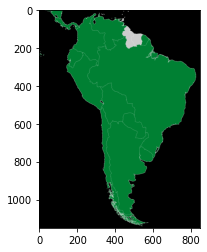

In [ ]:
#create mask for worldcloud
import cv2
import matplotlib.pyplot as plt

path = '/content/Sentiment-Analysis-DeepLearningCourse'

#reads image and crops it
image = cv2.imread(path + '/latinamericamap.png')
image = image[350:1500, 350:1500]
plt.imshow(image)

True

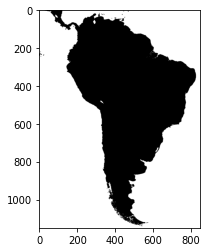

In [ ]:
#get mask from the image and saves it for later use
lower = np.array([0,0,0])
upper = np.array([40,255,40])
mask = cv2.inRange(image,lower,upper)
plt.imshow(mask, cmap = 'gray')
cv2.imwrite(img = mask, filename = '/content/LAmask.jpg')

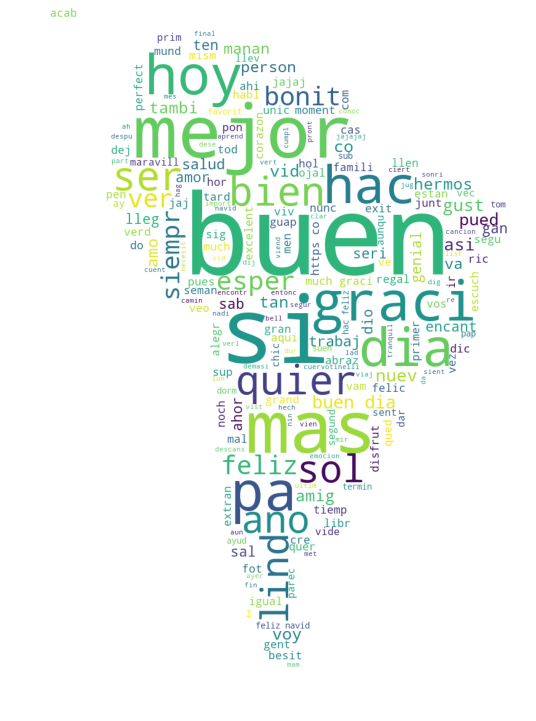

None


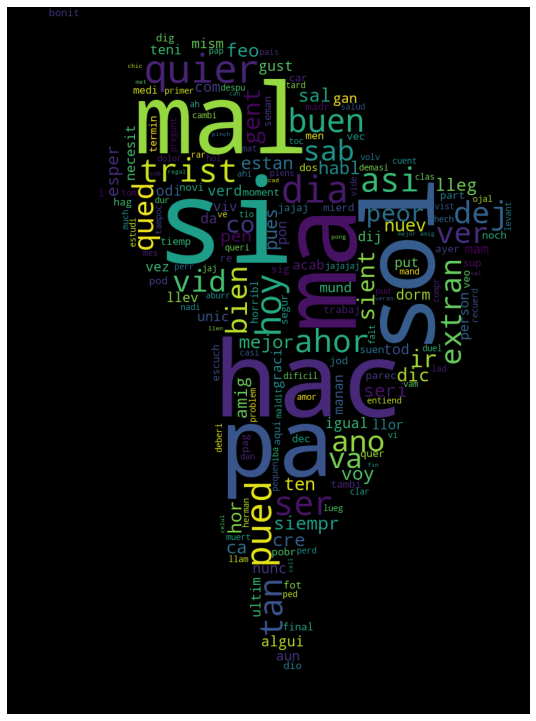

None


In [ ]:
#create wordcloud for positive and negative words using mask defined above

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image

#creates mask for worldcloud
LAmask = np.array(Image.open('/content/LAmask.jpg'))

def wordcloud_draw(data, color = 'white'):
  words = ' '.join(data)
  wordcloud = WordCloud(stopwords = stopwords,
                        background_color = color,
                        mask = LAmask
                        ).generate(words)
  plt.figure(1, figsize=(13,13))
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

print(wordcloud_draw(df['tweet'][df.sentiment == 'P'], color = 'white'))
print(wordcloud_draw(df['tweet'][df.sentiment == 'N'], color = 'black'))

# **Parte 4 - Ensamble y entrenamiento de la red neuronal LSTM**
Para entrenar la red neuronal primero transformaremos los tweets en vectores utilizando la función Tokenizer de Keras y separaremos el dataset en train, test y validation.
La red neuronal constará de las siguientes capas:
- Embedding
- Dropout(0.5)
- LSTM de 8 unidades
- Densa de 2 unidades y activación sigmoid 

Para la capa de embedding utilizaremos un output_dim relacionado a la cantidad de las palabras presentes en el dataset.
Compilaremos el modelo utilizando el optimizador adam, la función de loss binary_crossentropy y accuracy para las métricas. Entrenaremos la red durante 10 epochs y un batch_size de 32 teniendo poco más de 90 mil parámetros entrenables.


In [ ]:
#trains tokenizer with the tweets

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#the features will be the amount of words
max_features = countVector.shape[1]

#initilize Tokenizer
tokenizer = Tokenizer(num_words = max_features, split =' ')

#training
tokenizer.fit_on_texts(df['tweet'].values)

#transforms tweets in numeric arrays
X1 = tokenizer.texts_to_sequences(df['tweet'].values)

#transforms all sequences into same length
X = pad_sequences(X1)

In [ ]:
#prepare train and test dataset
from sklearn.model_selection import train_test_split

#dummies for sentiment
Y = pd.get_dummies(df['sentiment']).values

#train and test separation
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33, random_state = 42)

In [ ]:
#create validation set with 500 tweets
validation_size = 500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]

In [ ]:
#assembling of neural network
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

# embedding dimension will be 4th root of the amout of words (=9)
embed_dim = int(countVector.shape[1]**0.25)

model = Sequential()
model.add(Embedding(input_dim = max_features, output_dim = embed_dim, input_length = X.shape[1]))
model.add(Dropout(0.5))
model.add(LSTM(8, dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(Y.shape[1], activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 22, 9)             89793     
_________________________________________________________________
dropout (Dropout)            (None, 22, 9)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 576       
_________________________________________________________________
dense (Dense)                (None, 2)                 18        
Total params: 90,387
Trainable params: 90,387
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#compile and train model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train, Y_train, batch_size = 32, epochs = 10, validation_data = (X_validate, Y_validate))

Epoch 1/10
148/148 [==============================] - 30s 29ms/step - loss: 0.6858 - accuracy: 0.5532 - val_loss: 0.6678 - val_accuracy: 0.5600
Epoch 2/10
148/148 [==============================] - 3s 20ms/step - loss: 0.6384 - accuracy: 0.6096 - val_loss: 0.5369 - val_accuracy: 0.7120
Epoch 3/10
148/148 [==============================] - 3s 20ms/step - loss: 0.4720 - accuracy: 0.8208 - val_loss: 0.4485 - val_accuracy: 0.8340
Epoch 4/10
148/148 [==============================] - 3s 19ms/step - loss: 0.3495 - accuracy: 0.8756 - val_loss: 0.3944 - val_accuracy: 0.8400
Epoch 5/10
148/148 [==============================] - 3s 20ms/step - loss: 0.2671 - accuracy: 0.9096 - val_loss: 0.3774 - val_accuracy: 0.8380
Epoch 6/10
148/148 [==============================] - 3s 19ms/step - loss: 0.2034 - accuracy: 0.9260 - val_loss: 0.3851 - val_accuracy: 0.8420
Epoch 7/10
148/148 [==============================] - 3s 19ms/step - loss: 0.1549 - accuracy: 0.9477 - val_loss: 0.4041 - val_accuracy: 0.836

In [ ]:
#check score and accuracy in test set
score,acc_lstm = model.evaluate(X_test, Y_test, batch_size = 8)
print("Score: %.2f" % (score))
print("Acc: %.2f" % (acc_lstm))

228/228 [==============================] - 1s 3ms/step - loss: 0.4332 - accuracy: 0.8541
Score: 0.43
Acc: 0.85


In [ ]:
import numpy as np
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
    
    if np.argmax(result) == np.argmax(Y_validate[x]):

        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1

print("pos_recall", pos_correct/pos_cnt*100, "%")
print("neg_recall", neg_correct/neg_cnt*100, "%")

1/1 - 1s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1

Recall:  0.8264248704663213


<Figure size 432x288 with 0 Axes>

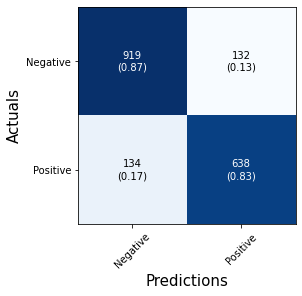

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

y_pred= model.predict(X_test).round()

# calculates confusion matrix
cnf_matrix = confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=3)

print("Recall: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# graph confusion matrix
labels = ['Negative', 'Positive']
plt.figure()
plot_confusion_matrix(conf_mat = cnf_matrix, figsize = (4,4), class_names = labels, show_absolute = True, show_normed = True )
plt.xlabel('Predictions', fontsize=15)
plt.ylabel('Actuals', fontsize=15)
plt.show()

# **Parte 6 - Entrenamiento utilizando un embedding pre-entrenado**
Para esta parte utilizaremos un embedding ya entrenado como punto de partida, el modelo viene en formato vectorial por lo que primero debemos extraer la matriz con los pesos.
La red neuronal LSTM a utilizar será la misma que la parte anterior de manera de comparar resultados.


In [ ]:
# =======================================
# TRAIN USING PRETRAINED MODEL
# =======================================
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

#route to where the .vec file should be
embedding_model_route = '/content/drive/MyDrive/embeddings-s-model.vec'

#load the model 
embedding_model = KeyedVectors.load_word2vec_format(embedding_model_route)

#extract the matrix with the weights
embedding_matrix = embedding_model.wv.syn0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


In [ ]:
#assembling of neural network
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

#embedding dimensions and input dimensions are related to the pre-trained embbeding
embed_dim_emb = embedding_matrix.shape[1]
max_features_emb = embedding_matrix.shape[0]

model_emb = Sequential()
model_emb.add(Embedding(input_dim = max_features_emb, output_dim = embed_dim_emb, weights = [embedding_matrix], trainable = True ))
model_emb.add(Dropout(0.5))
model_emb.add(LSTM(8, dropout = 0.2, recurrent_dropout = 0.2))
model_emb.add(Dense(Y.shape[1], activation = 'sigmoid'))
model_emb.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 30)          39402690  
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 30)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 1248      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 18        
Total params: 39,403,956
Trainable params: 39,403,956
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#compile and train model
model_emb.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_emb.fit(X_train, Y_train, batch_size = 32, epochs = 10, validation_data = (X_validate, Y_validate))

Epoch 1/10
148/148 [==============================] - 65s 409ms/step - loss: 0.6920 - accuracy: 0.5392 - val_loss: 0.6831 - val_accuracy: 0.5580
Epoch 2/10
148/148 [==============================] - 58s 391ms/step - loss: 0.6741 - accuracy: 0.5830 - val_loss: 0.6716 - val_accuracy: 0.5640
Epoch 3/10
148/148 [==============================] - 58s 391ms/step - loss: 0.6668 - accuracy: 0.5964 - val_loss: 0.6248 - val_accuracy: 0.6420
Epoch 4/10
148/148 [==============================] - 58s 391ms/step - loss: 0.6093 - accuracy: 0.6880 - val_loss: 0.5482 - val_accuracy: 0.7300
Epoch 5/10
148/148 [==============================] - 58s 391ms/step - loss: 0.5511 - accuracy: 0.7371 - val_loss: 0.5559 - val_accuracy: 0.7140
Epoch 6/10
148/148 [==============================] - 58s 391ms/step - loss: 0.4932 - accuracy: 0.7707 - val_loss: 0.5064 - val_accuracy: 0.7460
Epoch 7/10
148/148 [==============================] - 58s 390ms/step - loss: 0.4639 - accuracy: 0.7886 - val_loss: 0.5376 - val_ac

In [ ]:
#check score and accuracy in test set
score,acc_lstm_emb = model_emb.evaluate(X_test, Y_test, batch_size = 8)
print("Score: %.2f" % (score))
print("Acc: %.2f" % (acc_lstm_emb))

228/228 [==============================] - 1s 3ms/step - loss: 0.4944 - accuracy: 0.7910
Score: 0.49
Acc: 0.79


In [ ]:
import numpy as np
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model_emb.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
    
    if np.argmax(result) == np.argmax(Y_validate[x]):

        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1

print("pos_recall", pos_correct/pos_cnt*100, "%")
print("neg_recall", neg_correct/neg_cnt*100, "%")

1/1 - 1s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1

Recall:  0.8264248704663213


<Figure size 432x288 with 0 Axes>

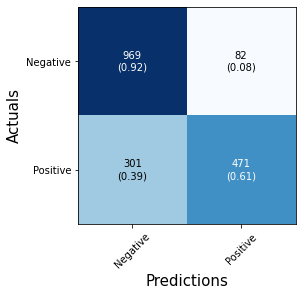

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

y_pred= model_emb.predict(X_test).round()

# calculates confusion matrix
cnf_matrix_emb = confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=3)

print("Recall: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# graph confusion matrix
labels = ['Negative', 'Positive']
plt.figure()
plot_confusion_matrix(conf_mat = cnf_matrix_emb, figsize = (4,4), class_names = labels, show_absolute = True, show_normed = True )
plt.xlabel('Predictions', fontsize=15)
plt.ylabel('Actuals', fontsize=15)
plt.show()

# **Parte 7 - Clasificación utilizando modelos de Machine Learning y n-grams**
En esta parte utilizaremos clasificadores de Machine Learning para predecir el sentimiento. Pimero modificaremos un poco el dataset con el fin de poder armar n-grams, lo dividiremos entre train y test y posteriormente crearemos los n-grams que utilizaremos para entrenar.

In [ ]:
#creates sentiment numeric label in new column
df['sentiment_index'] = df['sentiment'].apply(lambda x: 1 if x == 'P' else 0)

#get every clean tweet as a list into a new column
df['tweet_list'] = df['tweet'].apply(lambda x: x.split(sep=' '))

In [ ]:
#will use countvectorizer to convert tweets into bigrams, trigrams and tfidf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text

#initialize uni-grams, bigrams, trigrams and tfidf
unigram_converter = unigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[1,1], lowercase = False)
bigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[2,2], lowercase = False) 
trigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[3,3], lowercase = False)
tfidf_transform = text.TfidfTransformer(norm=None)

In [ ]:
#separate train, test sets
from sklearn.model_selection import train_test_split

#train and test separation
train_data, test_data = train_test_split(df, test_size = 0.33, random_state = 42)

In [ ]:
# #check shapes
print(train_data.shape)
print(test_data.shape)

(4714, 6)
(2323, 6)


In [ ]:
#labels
Y_train_ngram = train_data['sentiment_index']
Y_test_ngram = test_data['sentiment_index']

#train
X_train_unigram = unigram_converter.fit_transform(train_data['tweet_list'])
X_train_bigram = bigram_converter.fit_transform(train_data['tweet_list'])
X_train_trigram = trigram_converter.fit_transform(train_data['tweet_list'])

#uni-grams will be transformed into tf-idf
X_train_tfidf = tfidf_transform.fit_transform(X_train_unigram)

#test
X_test_unigram = unigram_converter.transform(test_data['tweet_list'])
X_test_bigram = bigram_converter.transform(test_data['tweet_list'])
X_test_trigram = trigram_converter.transform(test_data['tweet_list'])
X_test_tfidf = tfidf_transform.transform(X_test_unigram)

Teniendo los bi-gramas, tri-gramas y tf-idf entrenaremos los siguientes modelos con las tres configuraciones mencionadas para luego compararlos:
- K-nearest neighbour
- Decision Tree
- Random Forest
- Stochastic Gradient Descent

# **K-nearest neighbour**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

def knn_classification(X_train, Y_train, X_test, Y_test, desc):
  #initilize model
  knn = KNeighborsClassifier(n_neighbors = 5)
  #fits model
  knn.fit(X_train,Y_train)
  #predicts
  y_pred = knn.predict(X_test)
  #accuracy
  acc = round(knn.score(X_test,Y_test) * 100, 2)
  print('Accuracy using {}: {}'.format(desc, acc))

  #calculates confusion matrix
  cnf_matrix = confusion_matrix(Y_test, y_pred)

  return cnf_matrix, acc

In [ ]:
cnf_bigram_knn, acc_bigram_knn = knn_classification(X_train_bigram, Y_train_ngram, X_test_bigram, Y_test_ngram, 'bigram')
cnf_trigram_knn, acc_trigram_knn = knn_classification(X_train_trigram, Y_train_ngram, X_test_trigram, Y_test_ngram, 'trigram')
cnf_tfidf_knn, acc_tfidf_knn = knn_classification(X_train_tfidf, Y_train_ngram, X_test_tfidf, Y_test_ngram, 'tfidf')

Accuracy using bigram: 65.43
Accuracy using trigram: 58.98
Accuracy using tfidf: 64.31


<Figure size 432x288 with 0 Axes>

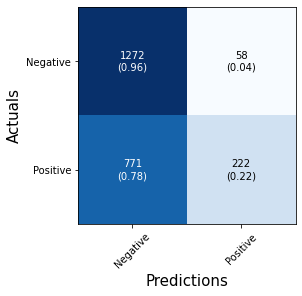

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

#choose one of the three confusion matrix to graph
cnf_matrix = cnf_tfidf_knn

# graph confusion matrix
labels = ['Negative', 'Positive']
plt.figure()
plot_confusion_matrix(conf_mat = cnf_matrix, figsize = (4,4), class_names = labels, show_absolute = True, show_normed = True )
plt.xlabel('Predictions', fontsize=15)
plt.ylabel('Actuals', fontsize=15)
plt.show()

# **Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

def decision_tree_classification(X_train, Y_train, X_test, Y_test, desc):
  #initilize model
  decision_tree = DecisionTreeClassifier()
  #fits model
  decision_tree.fit(X_train,Y_train)
  #predicts
  y_pred = decision_tree.predict(X_test)
  #accuracy
  acc = round(decision_tree.score(X_test,Y_test) * 100, 2)
  print('Accuracy using {}: {}'.format(desc, acc))

  #calculates confusion matrix
  cnf_matrix = confusion_matrix(Y_test, y_pred)

  return cnf_matrix, acc

In [ ]:
cnf_bigram_dt, acc_bigram_dt = decision_tree_classification(X_train_bigram, Y_train_ngram, X_test_bigram, Y_test_ngram, 'bigram')
cnf_trigram_dt, acc_trigram_dt  = decision_tree_classification(X_train_trigram, Y_train_ngram, X_test_trigram, Y_test_ngram, 'trigram')
cnf_tfidf_dt, acc_tfidf_dt  = decision_tree_classification(X_train_tfidf, Y_train_ngram, X_test_tfidf, Y_test_ngram, 'tfidf')

Accuracy using bigram: 78.39
Accuracy using trigram: 74.34
Accuracy using tfidf: 82.26


<Figure size 432x288 with 0 Axes>

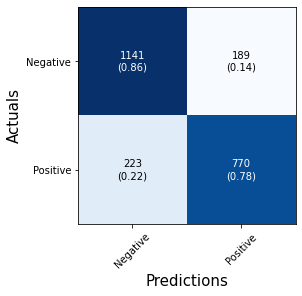

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

#choose one of the three confusion matrix to graph
cnf_matrix = cnf_tfidf_dt

# graph confusion matrix
labels = ['Negative', 'Positive']
plt.figure()
plot_confusion_matrix(conf_mat = cnf_matrix, figsize = (4,4), class_names = labels, show_absolute = True, show_normed = True )
plt.xlabel('Predictions', fontsize=15)
plt.ylabel('Actuals', fontsize=15)
plt.show()

# **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

def decision_tree_classification(X_train, Y_train, X_test, Y_test, desc):
  #initilize model
  random_forest = RandomForestClassifier(n_estimators=100)
  #fits model
  random_forest.fit(X_train,Y_train)
  #predicts
  y_pred = random_forest.predict(X_test)
  #accuracy
  acc = round(random_forest.score(X_test,Y_test) * 100, 2)
  print('Accuracy using {}: {}'.format(desc, acc))

  #calculates confusion matrix
  cnf_matrix = confusion_matrix(Y_test, y_pred)

  return cnf_matrix, acc

In [ ]:
cnf_bigram_rf, acc_bigram_rf = decision_tree_classification(X_train_bigram, Y_train_ngram, X_test_bigram, Y_test_ngram, 'bigram')
cnf_trigram_rf, acc_trigram_rf  = decision_tree_classification(X_train_trigram, Y_train_ngram, X_test_trigram, Y_test_ngram, 'trigram')
cnf_tfidf_rf, acc_tfidf_rf  = decision_tree_classification(X_train_tfidf, Y_train_ngram, X_test_tfidf, Y_test_ngram, 'tfidf')

Accuracy using bigram: 78.69
Accuracy using trigram: 74.3
Accuracy using tfidf: 85.71


<Figure size 432x288 with 0 Axes>

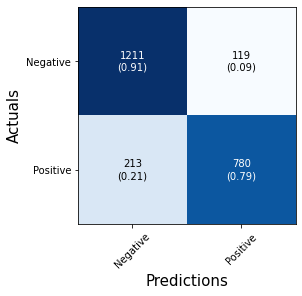

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

#choose one of the three confusion matrix to graph
cnf_matrix = cnf_tfidf_rf

# graph confusion matrix
labels = ['Negative', 'Positive']
plt.figure()
plot_confusion_matrix(conf_mat = cnf_matrix, figsize = (4,4), class_names = labels, show_absolute = True, show_normed = True )
plt.xlabel('Predictions', fontsize=15)
plt.ylabel('Actuals', fontsize=15)
plt.show()

# **Stochastic Gradient Decent**

In [ ]:
from sklearn.linear_model import SGDClassifier

def SGD_classification(X_train, Y_train, X_test, Y_test, desc):
  #initilize model
  sgd = SGDClassifier(max_iter=1000)
  #fits model
  sgd.fit(X_train,Y_train)
  #predicts
  y_pred = sgd.predict(X_test)
  #accuracy
  acc = round(sgd.score(X_test,Y_test) * 100, 2)
  print('Accuracy using {}: {}'.format(desc, acc))

  #calculates confusion matrix
  cnf_matrix = confusion_matrix(Y_test, y_pred)

  return cnf_matrix, acc

In [ ]:
cnf_bigram_sgd, acc_bigram_sgd = SGD_classification(X_train_bigram, Y_train_ngram, X_test_bigram, Y_test_ngram, 'bigram')
cnf_trigram_sgd, acc_trigram_sgd  = SGD_classification(X_train_trigram, Y_train_ngram, X_test_trigram, Y_test_ngram, 'trigram')
cnf_tfidf_sgd, acc_tfidf_sgd  = SGD_classification(X_train_tfidf, Y_train_ngram, X_test_tfidf, Y_test_ngram, 'tfidf')

Accuracy using bigram: 79.29
Accuracy using trigram: 74.56
Accuracy using tfidf: 84.12


<Figure size 432x288 with 0 Axes>

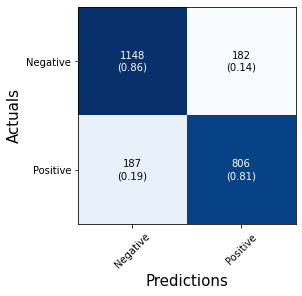

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

#choose one of the three confusion matrix to graph
cnf_matrix = cnf_tfidf_sgd

# graph confusion matrix
labels = ['Negative', 'Positive']
plt.figure()
plot_confusion_matrix(conf_mat = cnf_matrix, figsize = (4,4), class_names = labels, show_absolute = True, show_normed = True )
plt.xlabel('Predictions', fontsize=15)
plt.ylabel('Actuals', fontsize=15)
plt.show()

# **Comparación**
Se puede ver que la configuración con tf-idf performa mejor que con bigramas o trigramas para todos los modelos, llegando a resultados muy similares que utilizando una red neuronal LSTM

In [ ]:
models = pd.DataFrame({'Model': ['KNN', 'Decision Tree', 'Random Forest','Stochastic Gradient Decent'],
                      'Accuracy bigram': [acc_bigram_knn, acc_bigram_dt, acc_bigram_rf, acc_bigram_sgd],
                      'Accuracy trigram': [acc_trigram_knn, acc_trigram_dt, acc_trigram_rf, acc_trigram_sgd],
                      'Accuracy tf-idf': [acc_tfidf_knn, acc_tfidf_dt, acc_tfidf_rf, acc_tfidf_sgd]
                      })
models.sort_values(by='Accuracy tf-idf', ascending=False)

,Model,Accuracy bigram,Accuracy trigram,Accuracy tf-idf
2,Random Forest,78.69,74.30,85.71
3,Stochastic Gradient Decent,79.29,74.56,84.12
1,Decision Tree,78.39,74.34,82.26
0,KNN,65.43,58.98,64.31
